In [1]:
import numpy as np
#from scipy.interpolate import RectBivariateSpline
import scipy.interpolate as interpolate
import datetime as dt
import os
from copy import deepcopy as cp
import netCDF4 as nc
import sys
from dask import delayed
import matplotlib
import matplotlib.pyplot as plt
#import warnings
# Import writer class from csv module
from csv import writer
import xarray as xr
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.patches import Polygon
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
#SCENARIO_COMBNATION = ['frst-ctl','crop-ctl']
SCENARIO_COMBNATION = ['crop-ctl','frst-ctl','irri-crop']
scenario_title=['CROP-CTL','FRST-CTL','IRR-CROP']
# MODEL = ['mpiesm', 'cesm', 'ecearth'] #, "cesm" "ecearth" "mpiesem"
# CMOR_TABLE="Eyr"  # "Lmon" "LImon" "Emon" "Lmon" "Eyr" "Lmon"; choose "cesm" for all cesm variables as they are currently stored in /scratch/b/b380948/signal_separation/cesm_output/
# CMOR_VAR_table=['tas', 'tas-distribution', 'cLand'] #ah cesm model output data used with cesm table
region_list= ['CE', 'CSAM', 'ESAM']
region_name= ['EES', 'WAB', 'EAB']
#SCENARIO_COMBNATION = ['frst-ctl']
#region_list= ['NAM']
box_coords = [
    [(244,244,267,267,244), (29,54,54,29,29)],
    [(35,35,92,92,35), (43,60,60,43,43)],
    [(284,284,305,305,284), (-11,5,5,-11,-11)],
    [(11,11,32,32,11), (-9,8,8,-9,-9)],
    [(305,305,321,321,305), (-24,-3,-3,-24,-24)],
    [(14,14,35,35,14), (-23,-9,-9,-23,-23)],
    [(94,94,120,120,94), (24,41,41,24,24)]
]
region_names = [
    "WNA",  # Western North America
    "EES",  # East Europe Siberia
    "WAB",  # Western Amazon Basin
    "CCB",  # Central Congo Basin
    "EAB",  # Eastern Amazon Basin
    "SCP",  # Southern Congo Periphery
    "EC"    # Eastern China
]

def create_10level_cmap():
    # 从 "RdBu_r" 采样 10 个区分度高的颜色（蓝5 + 红5）
    cmap = cm.get_cmap('RdBu_r')
    colors = [cmap(i)[:3] for i in [0, 28, 56, 85, 113, 143, 170, 198, 226, 255]]
    return LinearSegmentedColormap.from_list('10level_cmap', colors, N=256)

i=2, j=0, index=0
i=3, j=0, index=3
i=2, j=1, index=1
i=3, j=1, index=4
i=2, j=2, index=2
i=3, j=2, index=5


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


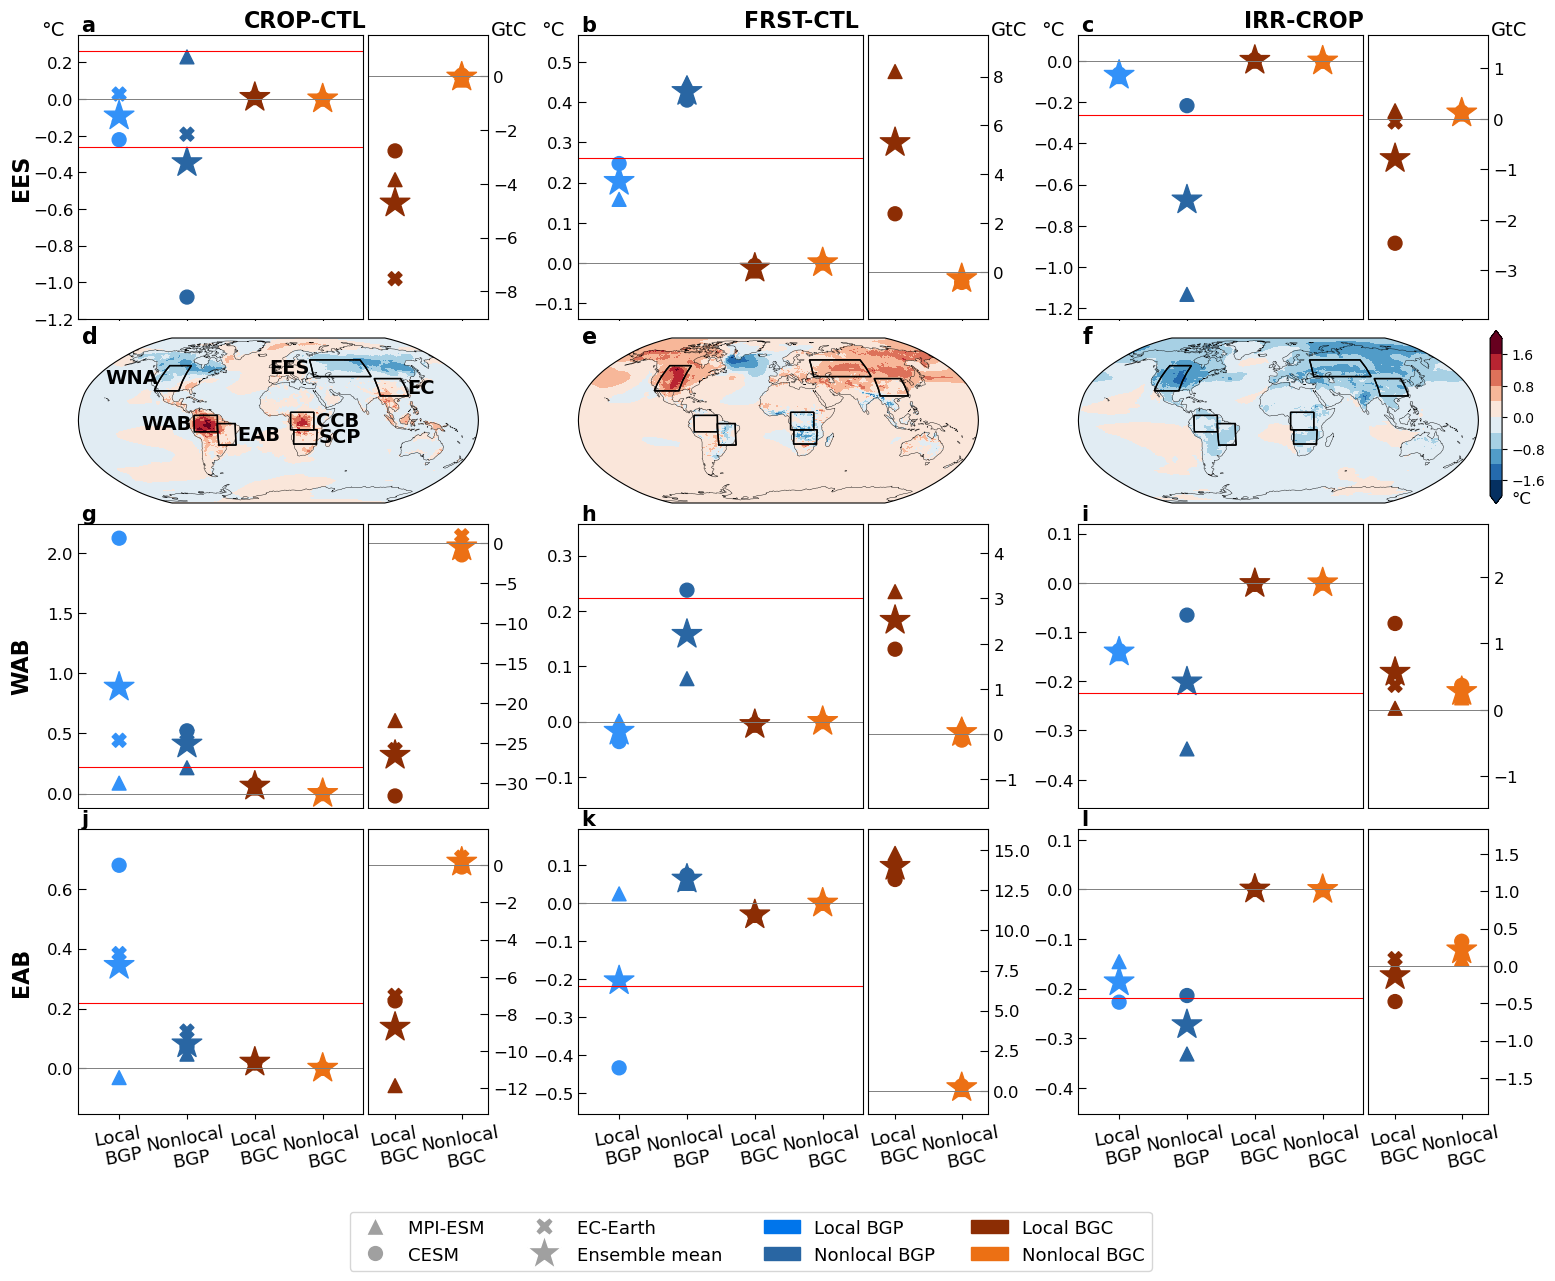

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

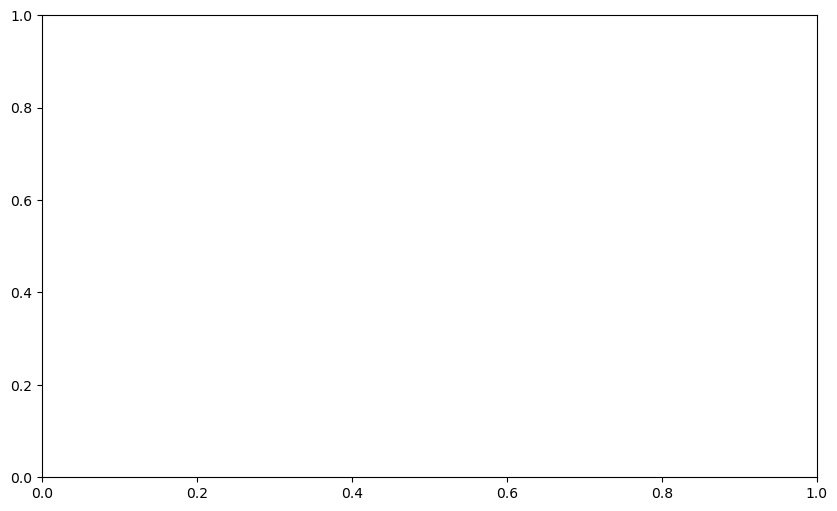

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [3]:
fig = plt.figure(constrained_layout=False)
subfigs = fig.subfigures(4,3, height_ratios=[1,0.6,1,1], wspace=0, hspace=0.02)
fig.set_size_inches(15, 11)  # 原来是 (15, 9)，增加高度给新图腾空间

for j, SCENARIO in enumerate(SCENARIO_COMBNATION):
 if SCENARIO == 'irri-crop':
     tas_global = xr.open_dataset(
        f"/work/bm1147/b380949/web-monitoring/secP/ensemble/tas_ensemble/model_ens/model_ens/tas_irr-crop_3models-ensemble.nc"
    )
 else:
     tas_global = xr.open_dataset(
        f"/work/bm1147/b380949/web-monitoring/secP/ensemble/tas_ensemble/model_ens/model_ens/tas_{SCENARIO}_3models-ensemble.nc"
    )
 tas_data = tas_global['tas_total'].isel(time=0)
 labels = list("def")  
 label_idx = j
    
 ax = subfigs[1, j].subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()})
 ax.text(0.01, 1.08, labels[j], transform=ax.transAxes,
                fontsize=16, fontweight='bold', va='top', ha='left')
 ax.set_position([0.005, 0.005, 0.8, 0.9])
 bounds = [-2, -1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6,2]
 norm = BoundaryNorm(bounds, 256)
 im = ax.pcolormesh(tas_data.lon, tas_data.lat, tas_data, 
                    transform=ccrs.PlateCarree(),
                    cmap=create_10level_cmap(), norm=norm)
 ax.set_xticks([])  # 去掉刻度防止重叠
 ax.set_yticks([])
 ax.set_aspect('auto')
 for idx, box in enumerate(box_coords):
                lon, lat = box
                poly = Polygon(list(zip(lon, lat)), closed=True,
                               transform=ccrs.PlateCarree(),
                               edgecolor='black', facecolor='none',
                               linewidth=1)
                ax.add_patch(poly)

                # 计算标注位置（左侧或右侧靠边）
                if idx <= 2:
        # 前3个区域，在左侧标注
                    text_lon = min(lon[:-1]) - 2
                    ha = 'right'
                else:
        # 后4个区域，在右侧标注
                    text_lon = max(lon[:-1]) + 2
                    ha = 'left'
            
                text_lat = sum(lat[:-1]) / len(lat[:-1])  # 使用纬度中值对齐

                if j==0:
                    ax.text(text_lon, text_lat, region_names[idx],
                        transform=ccrs.PlateCarree(),
                        fontsize=14, fontweight='bold',
                        color='black',
                        ha=ha, va='center')
                
 for box in box_coords:
            lon, lat = box
            poly = Polygon(list(zip(lon, lat)), closed=True,
                           transform=ccrs.PlateCarree(),
                           edgecolor='black', facecolor='none',
                           linewidth=1)
            ax.add_patch(poly)
   
 if j == 2:
    cax = inset_axes(ax,             # 关键：以 ax 为基准
                     width="9%",     # 相对于 ax 的宽度
                     height="90%",   # 相对于 ax 的高度
                     loc='lower left',
                     bbox_to_anchor=(0.6, -3.7, 1, 7),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    cbar = plt.colorbar(im, cax=cax,orientation='vertical',extend='both')
    cax.text(1.8, -0.065, '°C', transform=cax.transAxes, 
         ha='left', va='bottom', fontsize=12)
     
 ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
 
 ensemble_cland = xr.open_dataset('/work/bm1147/b380949/web-monitoring/secP/ensemble/cLand_ensemble/' + 'cLand_' + SCENARIO + '_last30mean_3models-ensemble_revised.nc')
 cland_map=ensemble_cland.cLand_local
#for SCENARIO in ['crop-ctl']:
#mv $SCRATCH/TCRE/GLOBAL/cLand_${SCENARIO}_mpiesm_Lut_last30mean_chname_GLOBAL_invertlat.nc $SCRATCH/TCRE/GLOBAL/cLand_${SCENARIO}_mpiesm_Lut_last30mean_chname_GLOBAL.nc
 for i, region_source in enumerate(region_list):
    ensemble_cland = xr.open_dataset('/work/bm1147/b380949/web-monitoring/secP/ensemble/cLand_ensemble/' + 'cLand_' + SCENARIO + '_last30mean_3models-ensemble_revised.nc')
    mpiesm_cland_dir_GHG = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/Lutdata/TCRE/perarea/' + region_source + \
    '/tas_fldmean_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_' + region_source + '_' + region_source + '.nc')
     # the direct AFOLU emission(local BGC effects) of $region_source impact its own regional mean temperature via GHG effect 
    mpiesm_cland_dir_GHG_onglobal = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/Lutdata/TCRE/perarea/' + region_source + \
    '/tas_fldmean_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_' + region_source + '_' + 'GLOBAL' + '.nc')
     # the direct AFOLU emission(local BGC effects) of CSAM impact $region_source 's regional mean temperature via GHG effect
    mpiesm_cland_dir_GHG_global_nonlocal = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/Lutdata/TCRE/perarea/GLOBAL' + \
    '/tas_fldmean_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_' + 'GLOBAL' + '_' + region_source + '.nc')
     # global nonlocal BGC effects induced emission impact $region_source 's regional mean temperature via GHG effect
    
    mpiesm_cland_dir_cLand = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/Lutdata/TCRE/perarea/' + region_source + \
    '/Eluc_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_' + region_source + '.nc')
     # mpiesm_cland_dir_cLand.cLand_local.values[0][0][0]*-1000: the direct AFOLU emission(regional integrated local BGC effects) of $region_source;
     # mpiesm_cland_dir_cLand.cLand_nonlocal.values[0][0][0]*-1000:the regional integrated nonlocal BGC effect of $region_sources(caused by the global AFOLU induced nonlocal BGP effects on this unchanged region-$region_source) 
    mpiesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/climate/regional_mean/' + \
    'tas_fldmean_' + SCENARIO + '_mpiesm_ensmean_signal-separated_' + region_source + '.nc')
    #mpiesm_bgp_dir_tas.tas_local.values[0][0][0]: AFOLU of $region_source induced $region_source 's regional mean temperature change via local BGP effects
    #mpiesm_bgp_dir_tas.tas_nonlocal.values[0][0][0]: global AFOLU induced $region_source(intact) 's regional mean temperature change via nonlocal BGP effects
    cesm_cland_dir_GHG= xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/final_Lunit/RTCRE_regional/perarea/' + region_source + \
    '/tas_fldmean_' + SCENARIO + '_cesm_last30mean_' + region_source + '_' + region_source + '.nc')
    cesm_cland_dir_GHG_onglobal= xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/final_Lunit/RTCRE_regional/perarea/' + region_source + \
    '/tas_fldmean_' + SCENARIO + '_cesm_last30mean_' + region_source + '_GLOBAL' + '.nc')
    cesm_cland_dir_GHG_global_nonlocal= xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/final_Lunit/RTCRE_regional/perarea/GLOBAL' + \
    '/tas_fldmean_' + SCENARIO + '_cesm_last30mean_' + 'GLOBAL' + '_' + region_source + '.nc')
    cesm_cland_dir_cLand= xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/final_Lunit/RTCRE_regional/perarea/' + region_source + \
    '/Eluc_' + SCENARIO + '_cesm_last30mean_' + region_source + '.nc')

    if SCENARIO == 'irri-crop':
        cesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/regional_mean/' + \
                                           '/TREFHT_fldmean_irr-crop_cesm_ensmean_signal-separated_'  + region_source + '.nc')
        ecearth_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/regional_mean/' + \
                                              '/2t_fldmean_irr-crop_ecearth_ensmean_signal-separated_'  + region_source + '_chname.nc')
        #considering that the water cycle is not fully coupled in EC-Earth.irrigation won't influence atmosphere directly 
        ecearth = [np.nan,np.nan,np.nan,np.nan]
        ecearth_cland_dir_cLand = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/RTCRE_regional/perarea/' + region_source + \
        '/Eluc_' + SCENARIO + '_ecearth_last30mean_gridlevelsep_' + region_source + '.nc')
        ecearth2 = [ecearth_cland_dir_cLand.cLand_local.values[0][0][0]*-1000, np.nan]
    else:
        if SCENARIO == 'frst-ctl':
            cesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/regional_mean/' + \
                                           '/TREFHT_fldmean_' + SCENARIO + '_cesm_ensmean_signal-separated_'  + region_source + '.nc')
            ecearth_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/regional_mean/' + \
                                              '/2t_fldmean_' + SCENARIO + '_ecearth_ensmean_signal-separated_'  + region_source + '_chname.nc')
            #considering that EC-Earth has low afforestation fraction diverging substaintially from the other two models
            ecearth = [np.nan,np.nan,np.nan,np.nan]
   
            ecearth_cland_dir_cLand = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/RTCRE_regional/perarea/' + region_source + \
            '/Eluc_' + SCENARIO + '_ecearth_last30mean_gridlevelsep_' + region_source + '.nc')
             #considering that EC-Earth has low afforestation fraction diverging substaintially from the other two models
            ecearth2 = [np.nan,np.nan]
        else:
            cesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/regional_mean/' + \
                                           '/TREFHT_fldmean_' + SCENARIO + '_cesm_ensmean_signal-separated_'  + region_source + '.nc')
            ecearth_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/regional_mean/' + \
                                              '/2t_fldmean_' + SCENARIO + '_ecearth_ensmean_signal-separated_'  + region_source + '_chname.nc')
            ecearth = [ecearth_bgp_dir_tas.tas_local.values[0][0][0],ecearth_bgp_dir_tas.tas_nonlocal.values[0][0][0],np.nan,np.nan]

            ecearth_cland_dir_cLand = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/RTCRE_regional/perarea/' + region_source + \
            '/Eluc_' + SCENARIO + '_ecearth_last30mean_gridlevelsep_' + region_source + '.nc')
            ecearth2 = [ecearth_cland_dir_cLand.cLand_local.values[0][0][0]*-1000, ecearth_cland_dir_cLand.cLand_nonlocal.values[0][0][0]*-1000]
            
    mpiesm = [mpiesm_bgp_dir_tas.tas_local.values[0][0][0], mpiesm_bgp_dir_tas.tas_nonlocal.values[0][0][0], mpiesm_cland_dir_GHG.tas_local.values[0][0][0], \
        mpiesm_cland_dir_GHG_global_nonlocal.tas_nonlocal.values[0][0][0]]
    mpiesm2 = [mpiesm_cland_dir_cLand.cLand_local.values[0][0][0]*-1000, mpiesm_cland_dir_cLand.cLand_nonlocal.values[0][0][0]*-1000]
    cesm2 = [cesm_cland_dir_cLand.cLand_local.values[0][0][0]*-1000, cesm_cland_dir_cLand.cLand_nonlocal.values[0][0][0]*-1000]
    cesm = [cesm_bgp_dir_tas.TREFHT_local.values[0][0][0],cesm_bgp_dir_tas.TREFHT_nonlocal.values[0][0][0], cesm_cland_dir_GHG.tas_local.values[0][0][0], \
    cesm_cland_dir_GHG_global_nonlocal.tas_nonlocal.values[0][0][0]]
    ensemble_arr=[cesm,mpiesm,ecearth]
    ensemble_arr2=[cesm2,mpiesm2,ecearth2] 
    ensemble= np.nanmean(ensemble_arr,axis=0)
    ensemble2= np.nanmean(ensemble_arr2,axis=0)
     
    colors = ['#3291F8', '#2966A3', '#8C2D04', '#EC7014']
    color2 = ['#8C2D04', '#EC7014']
    if region_source =='ESAM':
        labels = ['Local\n BGP','Nonlocal\n BGP','Local\n BGC','Nonlocal\n BGC']
        label2 = ['Local\n BGC','Nonlocal\n BGC']
    else:
        labels = ['','','','']
        label2 = ['','']
    x = [1,1.25,1.5,1.75]  # the label locations
    x2 = [1.25,1.75]
    region_name_output=region_name[i]
    if i>0:
        i=i+1
    subfig = subfigs[i,j]
    ax1, ax2 = subfig.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1.2]}) 
    #plt.subplots_adjust(wspace=0.05, hspace=0.05)
    ax1.set_position([0.005, 0.005, 0.57, 0.93])
    ax2.set_position([0.585, 0.005, 0.24, 0.93])
    ax1.set_facecolor('none')#transparent background
    ax2.set_facecolor('none')#transparent background
    #fig.tight_layout(pad=0.0)
    plt.figure(figsize=(10, 6))
    if j==0:
        ax1.text(-0.24, 0.5, region_name_output, fontsize=16, rotation=90,fontweight='bold',
         verticalalignment='center', horizontalalignment='left', transform=ax1.transAxes)
    else:
        ax1.text(-0.02, 0.5, None, fontsize=14, rotation=90,
         verticalalignment='center', horizontalalignment='left', transform=ax1.transAxes)
        ax1.set_ylabel(None)
    if i==0:
        ax1.text(0.58, 1.05, scenario_title[j], fontsize=16, rotation=0,fontweight='bold',
         verticalalignment='center', horizontalalignment='left', transform=ax1.transAxes)
        
        ax1.text(-0.13, 1.05,'°C' , fontsize=14, rotation=0,
         verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes)
        ax2.text(1.32, 1.05,'GtC' , fontsize=14, rotation=0,
         verticalalignment='top', horizontalalignment='right', transform=ax2.transAxes)
    else: 
        subfig.suptitle(None)
        ax1.set_ylabel(None)
        ax2.set_ylabel(None)
    rects3 = ax1.scatter(x, cesm, marker= 'o', s=100, color=colors, label='cesm')
    rects5 = ax1.scatter(x, ecearth, marker= 'X',s=100, color=colors, label='ecearth')        
    rects1 = ax1.scatter(x , mpiesm,marker= '^', s=100, color=colors, label='mpiesm')
    rects10 = ax1.scatter(x, ensemble, marker= '*', s=500, color=colors, label='mean')
    all_values_ax1 = np.concatenate([mpiesm,cesm,ecearth,ensemble])
    all_values_ax1 = all_values_ax1[np.isfinite(all_values_ax1)]
    ax1.set_ylim([np.min(all_values_ax1) -0.12, np.max(all_values_ax1) +0.12])
    ax1.tick_params(axis='y', direction='in', length=6, labelsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, fontsize=13,rotation=10)
    ax1.axhline(0, color='grey', linewidth=0.7)
    ax1.margins(x=0.2)
    if region_source == 'CE':
     ax1.axhline(0.262,color='red',linewidth = 0.8)
     ax1.axhline(-0.262,color='red',linewidth = 0.8)
    else:
        if region_source == 'CSAM':
         ax1.axhline(0.223,color='red',linewidth = 0.8)
         ax1.axhline(-0.223,color='red',linewidth = 0.8)
        else:
            if region_source == 'ESAM':
             ax1.axhline(0.219,color='red',linewidth = 0.8)
             ax1.axhline(-0.219,color='red',linewidth = 0.8)     
  #  else:
    rects9 = ax2.scatter(x2 , cesm2,marker= 'o', s=100, color=color2, label='cesm')
    rects7 = ax2.scatter(x2 , mpiesm2,marker= '^',s=100, color=color2, label='mpiesm')
    rects11 = ax2.scatter(x2 , ecearth2,marker= 'X',s=100, color=color2, label='ecearth') 
    rects12 = ax2.scatter(x2, ensemble2, marker= '*', s=500, color=color2, label='mean') 
    all_values_ax2 = np.concatenate([mpiesm2,cesm2,ecearth2,ensemble2])
    all_values_ax2 = all_values_ax2[np.isfinite(all_values_ax2)]
    ax2.set_ylim([np.min(all_values_ax2) -1.5, np.max(all_values_ax2) +1.5])
    #ax2.set_ylabel('GtC',fontsize = 20,labelpad=1)
    #ax2.yaxis.set_label_position('right')  # This moves the label to the right
    # Move yticks to the right
    ax2.tick_params(axis='y', direction='in', length=6, labelsize=12, labelleft=False, labelright=True,right=True, left=False)
    ax2.set_xticks(x2)
    ax2.set_xticklabels(label2, fontsize=13,rotation=10)
    ax2.margins(x=0.4)
    ax2.axhline(0, color='grey', linewidth=0.7)
    if i<1:
        labels_ax1 = list("abc")  
        ax1.text(0.01, 1.07, labels_ax1[j], transform=ax1.transAxes,
                fontsize=15, fontweight='bold', va='top', ha='left') 
    else:
        labels_ax1_2 = list("ghijkl")   
        print(f"i={i}, j={j}, index={j + (i - 2) * 3}")
        index = j + (i - 2) * 3
        ax1.text(0.01, 1.07, labels_ax1_2[index], transform=ax1.transAxes,
                fontsize=15, fontweight='bold', va='top', ha='left') 
    ''' 
    for k, txt in enumerate(np.round(ensemble2, decimals=3)):
                ax2.annotate(txt, (x2[k]-0.1, np.min(all_values_ax2) -1.5),fontsize=11,rotation=10)
        
    for k, txt in enumerate(np.round(mpiesm2, decimals=3)):
                ax2.annotate(txt, (x2[k]-0.1, np.min(all_values_ax2) +3.5),fontsize=11,rotation=10)
        
    for k, txt in enumerate(np.round(ecearth2, decimals=3)):
                ax2.annotate(txt, (x2[k]-0.1, np.min(all_values_ax2) +8.5),fontsize=11,rotation=10)
        
    for k, txt in enumerate(np.round(cesm2, decimals=3)):
                ax2.annotate(txt, (x2[k]-0.1, np.min(all_values_ax2)+13.5),fontsize=11,rotation=10)
        
    for k, txt in enumerate(np.round(ensemble, decimals=5)):
                ax1.annotate(txt, (x[k]-0.1, np.min(all_values_ax1) -0.12),fontsize=11,rotation=10) 
    for k, txt in enumerate(np.round(mpiesm, decimals=5)):
                ax1.annotate(txt, (x[k]-0.1, np.min(all_values_ax1)+0.38),fontsize=11,rotation=10) 
    for k, txt in enumerate(np.round(cesm, decimals=5)):
                ax1.annotate(txt, (x[k]-0.1, np.min(all_values_ax1) +0.88),fontsize=11,rotation=10) 
    for k, txt in enumerate(np.round(ecearth, decimals=5)):
                ax1.annotate(txt, (x[k]-0.1, np.min(all_values_ax1) +1.38),fontsize=11,rotation=10) 
   '''     
legend_elements = [Line2D([0], [0], marker='^', color='w', label='MPI-ESM ',markerfacecolor='#A0A0A0', markersize=13),
                   Line2D([0], [0], marker='o', color='w', label='CESM ', markerfacecolor='#A0A0A0', markersize=12),
                   Line2D([0], [0], marker='X', color='w', label='EC-Earth ',markerfacecolor='#A0A0A0', markersize=13),
                   Line2D([0], [0], marker='*', color='w', label='Ensemble mean ', markerfacecolor='#A0A0A0', markersize=26),
                   Patch(color='#0075EB', label='Local BGP'),
                   Patch(color='#2966A3', label='Nonlocal BGP'),
                   Patch(color='#8C2D04', label='Local BGC'),
                   Patch(color='#EC7014', label='Nonlocal BGC')
                  ] 
font_properties = FontProperties()
font_properties.set_family('serif')  # Set font family
font_properties.set_name('Times New Roman')  # Specific font name
#font_properties.set_weight('bold')  # Set font weight to bold
font_properties.set_size(13)  # Set font size

fig.legend(handles=legend_elements, loc='lower center',bbox_to_anchor=(0.45, -0.15),ncol=4,prop=font_properties )
#plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('/scratch/b/b380949/' + 'NC-Fig3_regionname.pdf', format = 'pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)

#fig.savefig('/work/bm1147/b380949/web-monitoring/secP/Fig3_agriculturestakeholder/' + 'NC-Fig3_regionname.jpg', format = 'jpg', bbox_inches='tight', pad_inches=0.1, dpi=300)
#fig.savefig('/work/bm1147/b380949/web-monitoring/secP/Fig3_agriculturestakeholder/' + 'Fig3_scatter_perarea_data_revised_inconsistent_withdata.png', format = 'png', bbox_inches='tight', pad_inches=0.1, dpi=300)
